## Notes

1. One general question: How many cells do we need in a transition region for a given set of fine and coarse discretizations?

2. IS there any difference in the type of grading function we use to make the transition? Currently the default is log

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver
import pyfd3d.fd3d as fd3d
import pyfd3d.nonuniform_grid as nug
from scipy.sparse.linalg import qmr, bicgstab

In [2]:
Npml = np.array([10,10,10])

In [3]:
## we only need to have a nonuniform mesh in the x and y directions
Nfine = np.array([31,31]); #specify nx, ny for each region
Ncoarse = np.array([10,10]);
Ntran =   np.array([15,15]); # 2) specify the dx and dy of each region
Nz = 161
dx1 = 0.02; dy1 = 0.02;
dx2 = 0.005; dy2 = 0.005;
dz1 = 2/201
dfine = [dx2, dy2];
dcoarse = [dx1, dy1];
dtran = [0,0] ## dummy values needed

Ntot = Nfine+Ncoarse+Ntran+Ncoarse+Ntran
print(Ntot)


#stack the vectors
# drt does not have a value...
Nft = np.vstack((Ncoarse, Ntran, Nfine, Ntran, Ncoarse));
drt = np.vstack((dcoarse, dtran, dfine, dtran, dcoarse));

print(Nft)

# so discretization must be at coarse discretization, which is inconvenient if we specify fdfd using xrange and yrange


[81 81]
[[10 10]
 [15 15]
 [31 31]
 [15 15]
 [10 10]]


In [4]:
dr_reference  = dcoarse;
[dx_scale, dy_scale] = nug.generate_nonuniform_scaling(Nft, drt/dr_reference);

## still have to specify dz_scale
dz_scale = np.ones(Nz)

#convert into real micrometer units
dx = dx_scale*dx1
dy = dy_scale*dy1
dz = dz_scale*dz1

x = np.cumsum(dx)
y = np.cumsum(dy)
z = np.cumsum(dz)

xrange = [0, x[-1]]
yrange = [0, y[-1]]
zrange = [0, z[-1]]
Nx = len(dx_scale)
Ny = len(dy_scale)

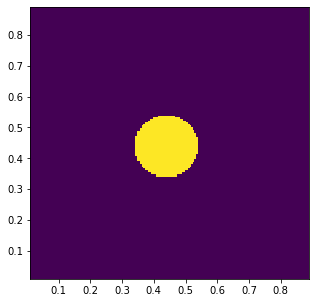

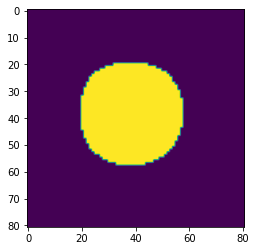

In [5]:
L0 = 1e-6

radius = 0.1


xx,yy = np.meshgrid(x,y, indexing = 'ij')
XX,YY,ZZ = np.meshgrid(x,y,z, indexing = 'ij')

slab_plane = 1*np.ones((Nx,Ny))

slab_plane[(xx-xrange[-1]/2)**2+(yy-yrange[-1]/2)**2<radius**2] = 4
plt.figure(figsize = (5,5))
plt.pcolormesh(xx,yy,slab_plane)
plt.figure()
plt.imshow(slab_plane)

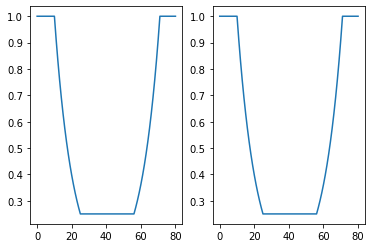

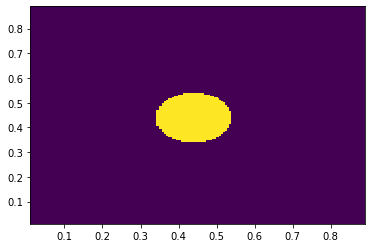

In [6]:
plt.figure();
plt.subplot(121)
plt.plot(dx_scale)
plt.subplot(122)
plt.plot(dy_scale)

plt.figure()
plt.pcolormesh(xx,yy,slab_plane)

In [7]:
## integrate slab structure into 3D grid
eps_r = np.ones((Nx,Ny,Nz))
N = [Nx,Ny,Nz]

In [8]:
print(eps_r.shape)
for k in range(0,Nz):
    eps_r[:,:,k] = slab_plane

(81, 81, 161)


## Convert dx_scale, dy_scale, dz_scale into operators

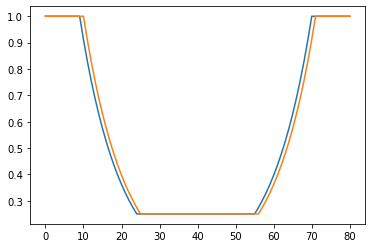

In [9]:
plt.plot(np.roll(dx_scale,-1))
plt.plot(dx_scale)

In [10]:
%%time
## inverse
dx_scale_0 = np.ones(Nx)
dy_scale_0 = np.ones(Ny)
dz_scale_0 = np.ones(Nz)

Fsx, Fsy, Fsz, Fsx_conj, Fsy_conj, Fsz_conj = nug.non_uniform_scaling_operator(dx_scale, dy_scale, dz_scale)

CPU times: user 45.9 ms, sys: 22.4 ms, total: 68.3 ms
Wall time: 67.2 ms


1056321
0.009950248756218905 0.02


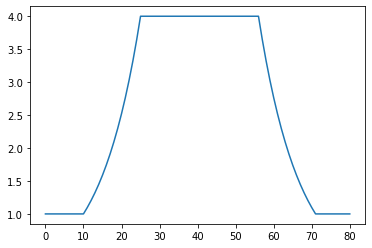

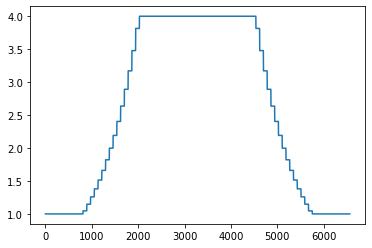

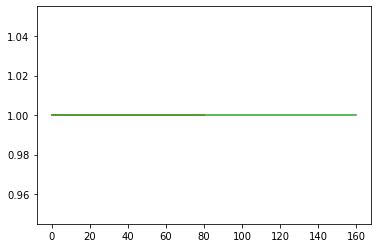

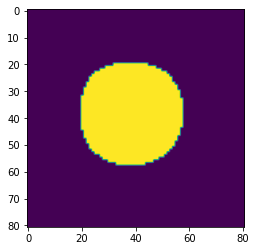

In [11]:
print(np.prod(N))
plt.figure()
plt.plot(Fsx.diagonal()[0:Nx])
plt.figure()
plt.plot(Fsy_conj.diagonal()[0:Nx*Ny])

print(dz1, dx1)
plt.figure()
plt.plot(dx_scale_0)
plt.plot(dy_scale_0)
plt.plot(dz_scale_0)

plt.figure();
plt.imshow(slab_plane)

In [12]:
print(N)

[81, 81, 161]


In [13]:
Jz = np.zeros(N); 
Jy = np.zeros(N);
Jx = np.zeros(N);

Jx[Nx//2,Ny//2,35] = 1;
Jy[Nx//2,Ny//2,35] = 1
eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r.copy(),
    'eps_zz': eps_r.copy(),
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}


In [14]:
print(dx1, dy1, dz1)
print(xrange, yrange, zrange,(np.sum(dx_scale))*dx1)

0.02 0.02 0.009950248756218905
[0, 0.8798374003755676] [0, 0.8798374003755676] [0, 1.6019900497512392] 0.8798374003755673


In [15]:
%%time
wvlen = 0.51;
print(L0, xrange, yrange, zrange)

# what is making this so slow?
A,b, Ch = fd3d.curlcurlE_nu(L0, 
                         wvlen, 
                         dx1,
                         dy1, 
                         dz1, 
                         dx_scale,
                         dy_scale,
                         dz_scale,
                         eps_r_tensor_dict, 
                         JCurrentVector,
                         Npml, 
                         s = -1
                        )

# A,b, Ch = fd3d.curlcurlE(L0, 
#                          wvlen, 
#                          xrange,
#                          yrange,
#                          zrange,
#                          eps_r_tensor_dict, 
#                          JCurrentVector,
#                          Npml, 
#                          s = -1
#                         )



1e-06 [0, 0.8798374003755676] [0, 0.8798374003755676] [0, 1.6019900497512392]
CPU times: user 8.92 s, sys: 3.15 s, total: 12.1 s
Wall time: 12.1 s


## Notes
1. hmmm, seems like bicg-stab fails on this system?

In [16]:
## ilu preconditioner?
from scipy.sparse.linalg import spilu


In [17]:
%%time
x, info = bicgstab(A,b, maxiter = 1500);
print(info)

1500
CPU times: user 52min 35s, sys: 33.2 s, total: 53min 8s
Wall time: 6min 39s


In [18]:
print(info) #system did not converge?

1500


In [19]:
y = Ch@x
print(y.shape, A.shape)

(3168963,) (3168963, 3168963)


In [20]:
M = np.prod(N);
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F')
Ez = x[2*M:].reshape(N, order = 'F')

Hx =  y[0:M].reshape(N, order = 'F')
Hy =  y[M:2*M].reshape(N, order = 'F')
Hz =  y[2*M:].reshape(N, order = 'F')


/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_98065/625975499.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


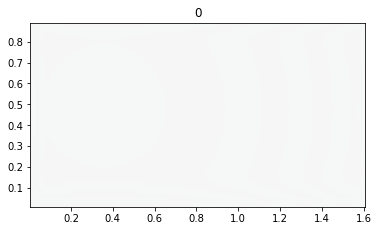

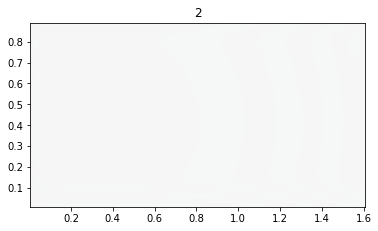

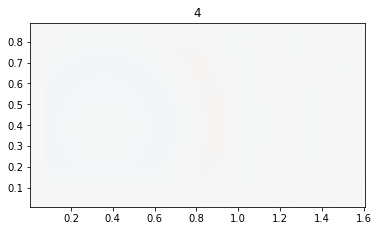

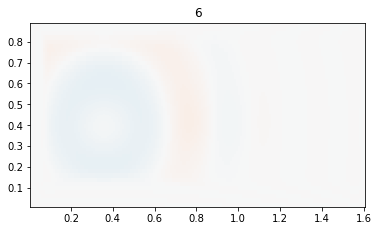

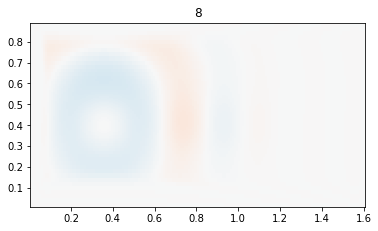

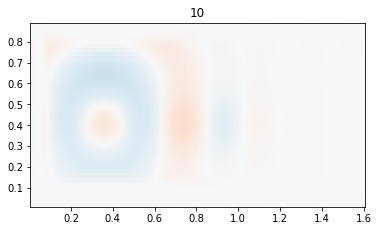

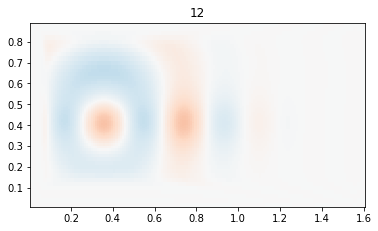

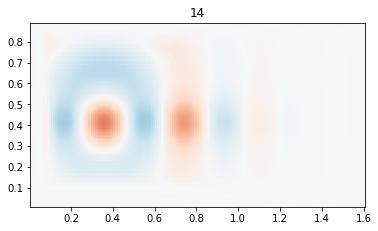

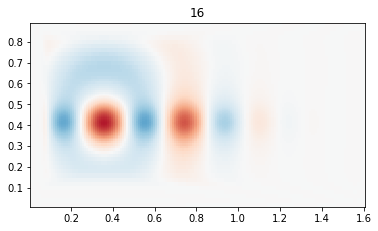

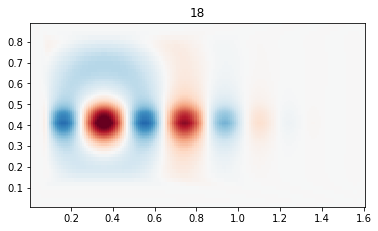

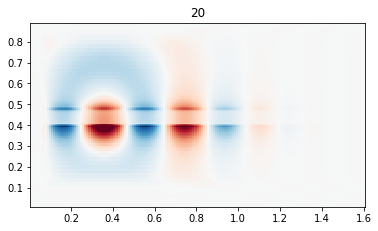

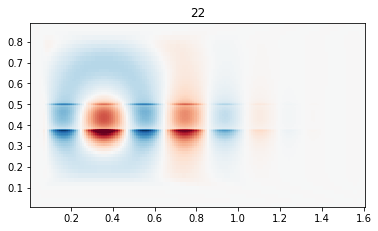

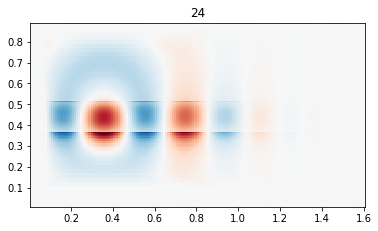

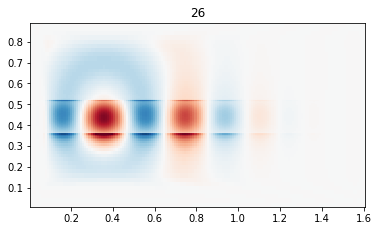

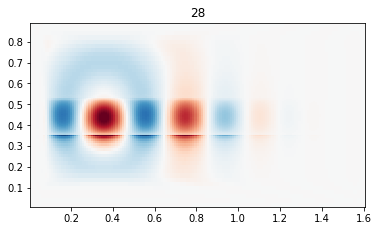

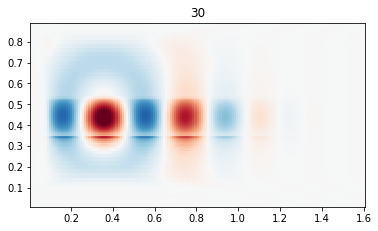

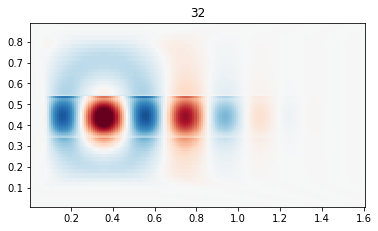

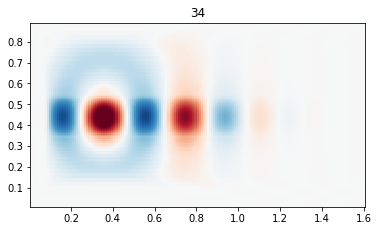

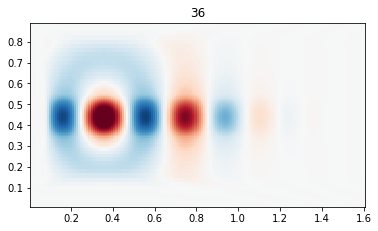

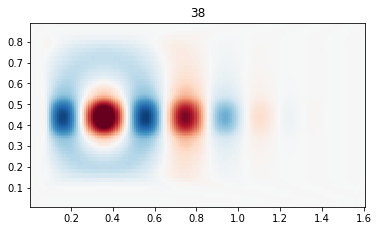

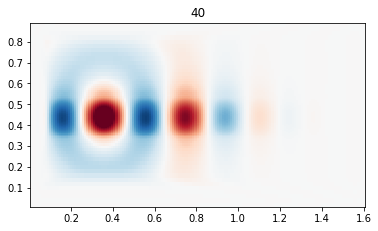

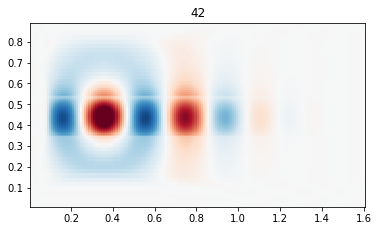

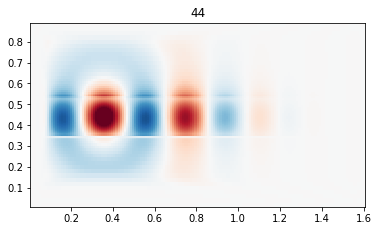

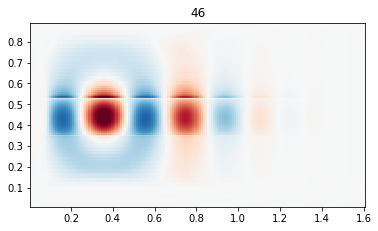

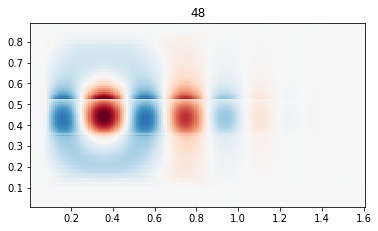

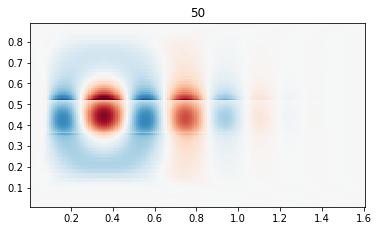

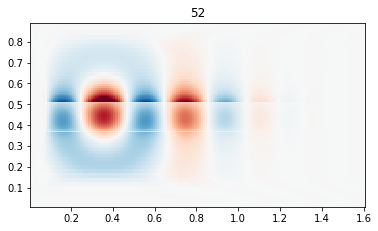

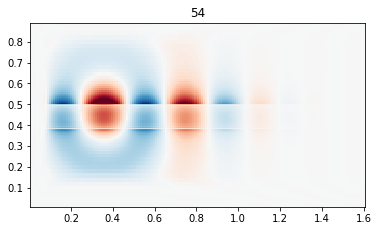

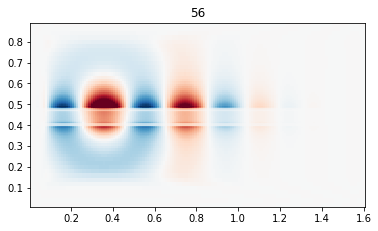

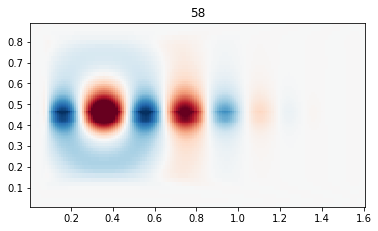

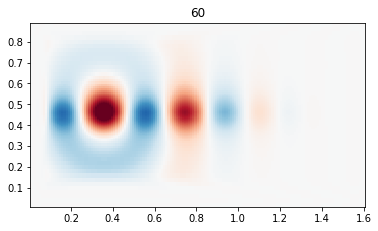

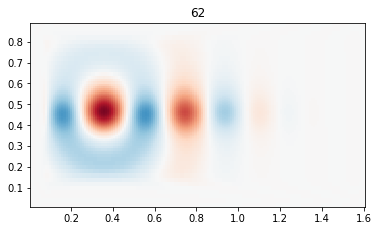

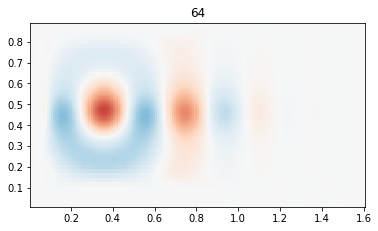

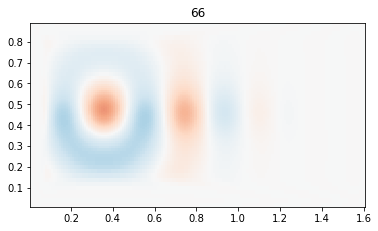

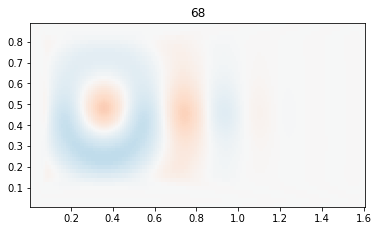

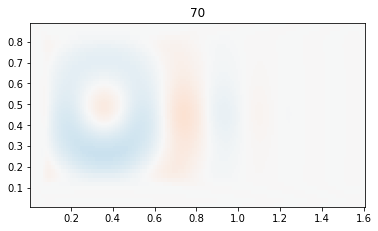

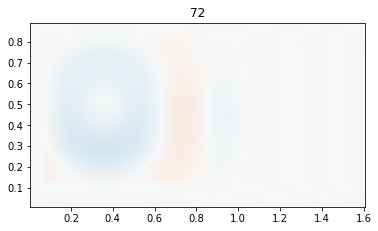

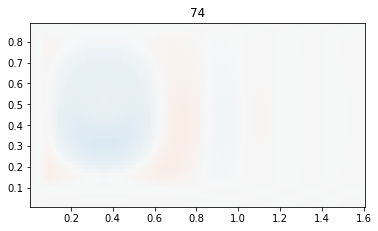

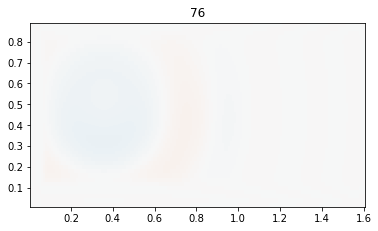

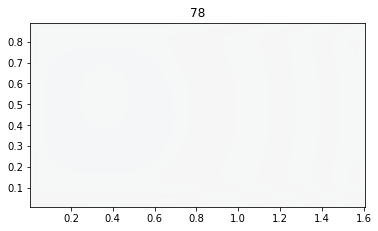

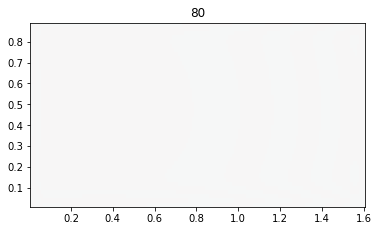

In [21]:
for i in range(0,N[0],2):
    plt.figure()
    ax = plt.subplot(111)
    plt.pcolormesh(ZZ[:,i,:], XX[:,i,:],np.real(Ey[:,i,:]), cmap = 'RdBu', linewidth = 0, rasterized = True)
    #plt.imshow(np.real(Ex[:,i,:]), cmap = 'RdBu')
    plt.clim(-1e-3, 1e-3)
    ax.set_aspect('equal')
    #plt.imshow(np.real(Ex[:,i,:]), cmap = 'RdBu')
    #plt.clim(-0.1e-2,0.1e-2)
    plt.title(i)
    #plt.colorbar()
#     if(i == 50):
#         plt.savefig('../img/3d_waveguide_abs_slice.png',dpi =300)
    

/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_98065/3291771739.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


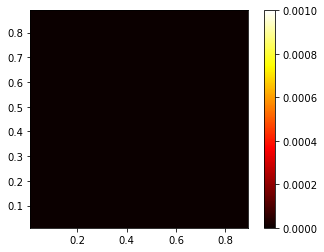

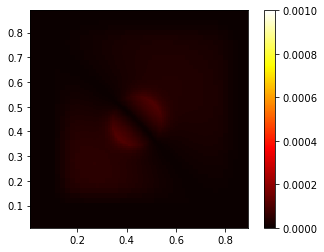

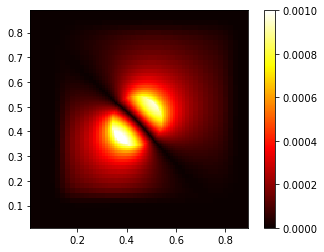

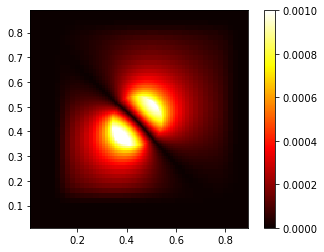

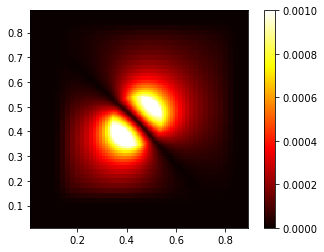

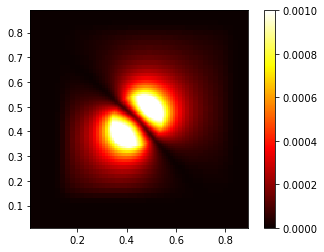

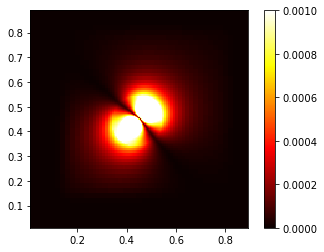

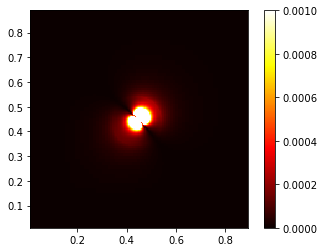

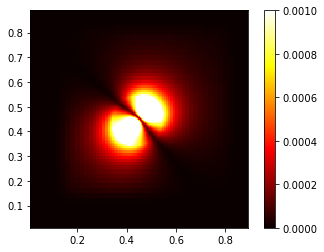

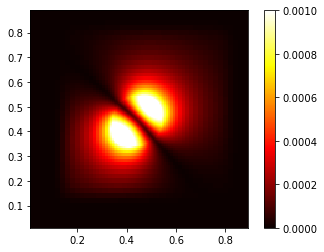

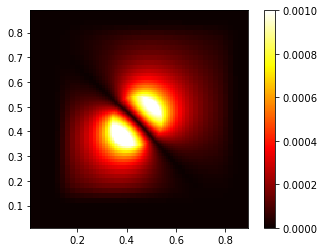

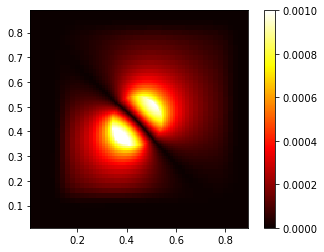

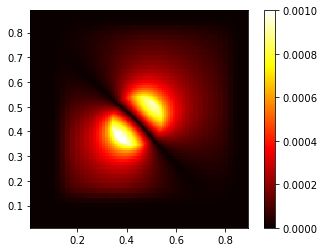

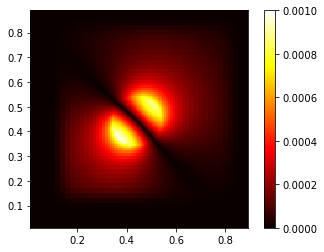

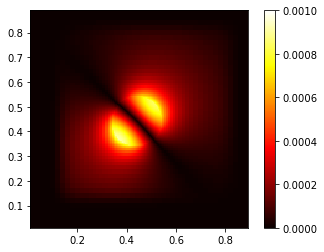

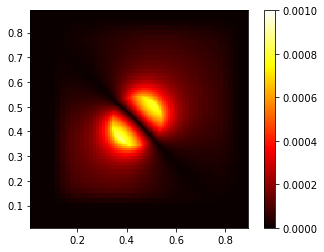

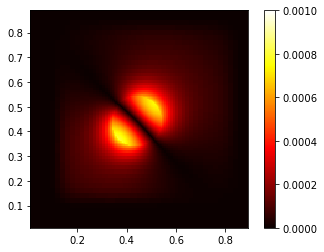

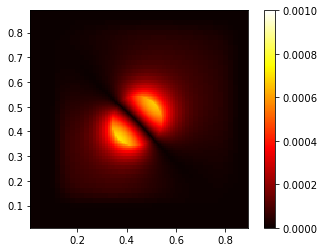

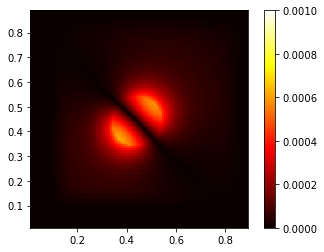

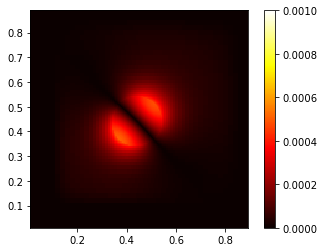

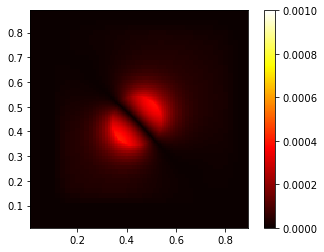

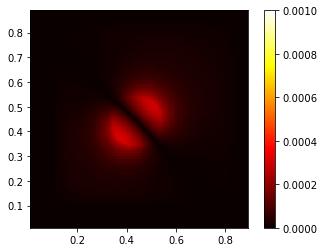

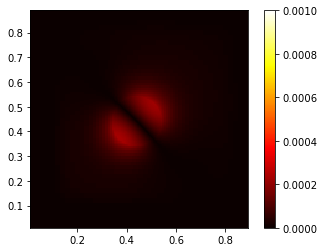

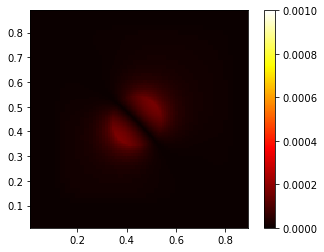

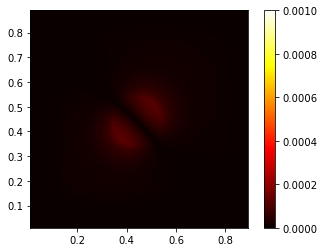

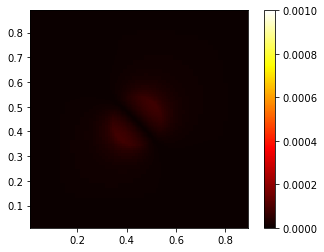

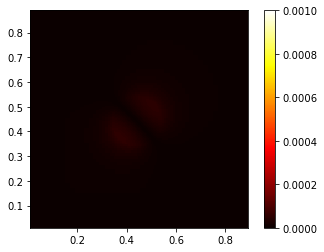

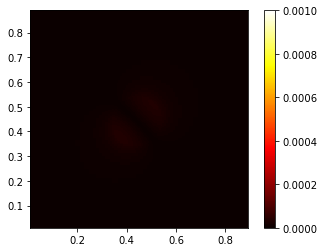

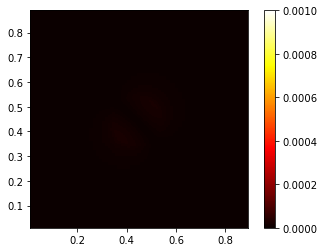

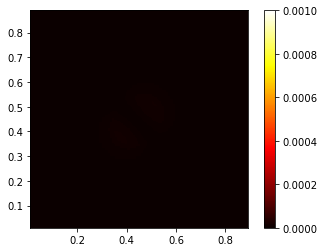

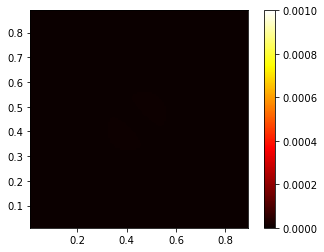

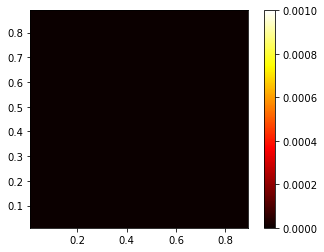

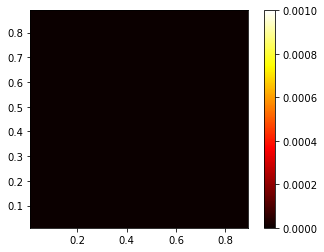

In [22]:
for i in range(0,N[-1],5):
    plt.figure()
    #plt.imshow(np.abs(Ez[:,:,i]), cmap = 'hot')
    ax = plt.subplot(111)
    plt.pcolormesh(xx,yy, np.abs(Ez[:,:,i]), cmap = 'hot')
    plt.clim(0,0.1e-2)
    ax.set_aspect('equal')
    plt.colorbar()
    
    #plt.plot(Ez[Nx//2,Ny//2,:])


error norm:  1.3303889721170255e-05
error norm should be small, ideally close to precision


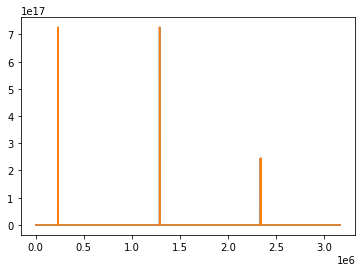

In [23]:
print('error norm: ',np.linalg.norm(A@x-b)/np.linalg.norm(b))
print('error norm should be small, ideally close to precision')
plt.plot(np.abs(A@x))
plt.plot(np.abs(b))
# plt.figure()
# plt.plot(np.log10(np.abs(A@x)))
# plt.plot(np.log10(np.abs(b)))


In [24]:
print(np.allclose(A@x, b))

False


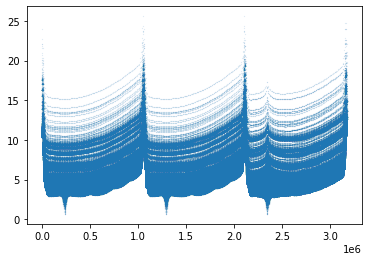

In [25]:
plt.plot(np.abs(np.log10(x)), '.', markersize = 0.1)

In [26]:

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.graph_objs import *

def get_the_slice(x,y,z, surfacecolor):
    return go.Surface(x=x,
                      y=y,
                      z=z,
                      surfacecolor=surfacecolor,
                      coloraxis='coloraxis')
def get_lims_colors(surfacecolor):# color limits for a slice
    return np.min(surfacecolor), np.max(surfacecolor)

Nx,Ny,Nz = N
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=2, z=1)
)

xs = np.linspace(xrange[0], xrange[1], Nx)
ys = np.linspace(yrange[0], yrange[1], Ny)
zs = np.linspace(zrange[1], zrange[0], Nz)

yy,zz, = np.meshgrid(ys,zs, indexing = 'ij');
xx = xs[30] * np.ones(yy.shape)

surfcolor_y = (np.real(Ex[30,:,:]))
surfcolor_z = (np.real(Ex[:,30,:]))
surfcolor_x = (np.real(Ex[:,:,150]))

slice_y = get_the_slice(xx,yy,zz, surfcolor_y)
slice_y.update(cmin=0, cmax=0.2e-2)


xx,zz, = np.meshgrid(ys,zs, indexing = 'ij');
yy = ys[30] * np.ones(yy.shape)
slice_z = get_the_slice(xx,yy,zz, surfcolor_z)
slice_z.update(cmin=0, cmax=0.2e-2)


xx,yy, = np.meshgrid(xs,ys, indexing = 'ij');
zz = zs[150] * np.ones(zz.shape)
slice_x = get_the_slice(xx,yy,zz, surfcolor_x)
slice_x.update(cmin=0, cmax=0.2e-2)


axis = dict(gridcolor="white",
            showbackground=False,
            linecolor="black",
            mirror = True, 
            showline = True)

layout = go.Layout(
         width=700,
         height=700,
         scene=dict(yaxis=axis,
                    xaxis=dict(axis, range = xrange),
                    zaxis=dict(axis, range = zrange),
                    aspectratio=dict(x=1, y=1, z=2)
                    ),
         scene_camera = camera,
        )
fig_data = [slice_y, slice_z, slice_x]

fig = go.Figure(data=fig_data, layout=layout)
fig.update_coloraxes(colorscale='RdBu')
#fig.write_image('../img/cylindrical_waveguide_Ex.png')
fig.show();

## try a direct solver
Since now we know a few cases, such as the PhC slab take an unacceptably long time, let's see if a pardiso factorization does better

In [27]:
# import pickle
# filehandler = open(b"../data/3d_cylindrical_waveguide_large.p","wb")
# pickle.dump((Ex, Ey, Ez, Hx, Hy, Hz, A, b, xrange, yrange, wvlen, N, eps_r),filehandler)

In [28]:
# #use unsymmetric case
# pSolve = pardisoSolver(A, mtype=13)

In [ ]:
# %%time
# pSolve.factor()


OMP: Info #271: omp_get_nested routine deprecated, please use omp_get_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [1]:
# x0 = pSolve.solve(b)
# plt.plot(np.abs(x0))
# plt.figure()
# Ex = np.reshape(x0[0:M],N)

# plt.imshow(np.abs(Ex[:,:,0]))